# Testing for conditional independence

# Import

In [4]:
import numpy as np
import torch

In [5]:
import matplotlib.pyplot as plt

In [7]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
import sys

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
device

device(type='cuda')

In [14]:
torch.manual_seed(42);

In [15]:
from sklearn.datasets import make_s_curve

In [16]:
import pandas as pd

In [17]:
# NOTE: adjust as needed
sys.path.append("src/DistributionalPrincipalAutoencoder")
sys.path.append("src/engression")
sys.path.append("src/mlcolvar")

/home/leban/research/ambuj/dpae-theory


In [18]:
from dpa.dpa_fit import DPA

# S-Curve

## Init

In [22]:
n = 10000
x_tr, color_tr = make_s_curve(n, noise=0.1, random_state=22)
x_te, color_te = make_s_curve(n, noise=0.1, random_state=222)

In [23]:
def plot_3d(points, points_color=None, title=None, save_dir=None):
    x, y, z = points.T
    fig, ax = plt.subplots(
        figsize=(5, 5),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    if title is not None:
        fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches='tight')
    plt.show()

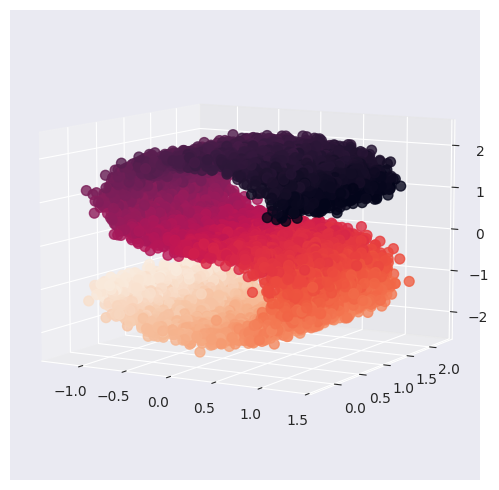

In [28]:
plot_3d(x_tr, color_tr)

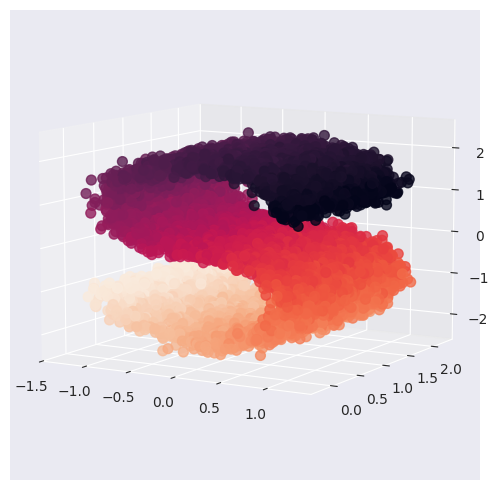

In [26]:
plot_3d(x_te, color_te)

## Train

In [24]:
from engression.data import loader

In [25]:
x_tr = torch.Tensor(x_tr).to(device)
x_tr_loader = loader.make_dataloader(x_tr, batch_size=500, shuffle=True,
                                     device="cpu")
x_te = torch.Tensor(x_te).to(device)

In [27]:
n_feats = 3
k = 3
num_layer = 4
hidden_dim = 100
latent_dims = list(range(k + 1))[::-1]


In [28]:
dpaModel_scurveS = DPA(beta=1,
                       dist_enc="deterministic",
                       dist_dec="stochastic",
                       data_dim=n_feats,
                       latent_dims=latent_dims,
                       num_layer=num_layer,
                       hidden_dim=hidden_dim,
                       noise_dim=100,
                       resblock=True,
                       standardize=True,
                       device=device,
                       seed=42
                       )

GPU is available, running on GPU.



In [29]:
prefix = f"res/models/indep/scurve/{k}k{num_layer}l{hidden_dim}hStand/"

In [46]:
dpaModel_scurveS.train(x_tr.to("cpu"),
                       x_te,
                       num_epochs=3000,
                       batch_size=3334,
                       lr=5e-4,
                       save_model_every=100,
                       save_dir=prefix,
                       save_loss=True,
                       resume_epoch=2000,
                       )

Resume training from epoch 2000
Start training with 3 batches each of size 3334.

[Epoch 2100] 0.0386, 0.0889, 0.5291, 1.1511
 pred 	0.0954, 0.1953, 1.0906, 2.2795
 var 	0.1136, 0.2128, 1.1230, 2.2568
(test)	0.0417, 0.0937, 0.5490, 1.1502
 pred 	0.0987, 0.1978, 1.0990, 2.2814
 var 	0.1140, 0.2083, 1.1001, 2.2623

[Epoch 2200] 0.0390, 0.0901, 0.5356, 1.1634
 pred 	0.0943, 0.1899, 1.0706, 2.2865
 var 	0.1106, 0.1996, 1.0699, 2.2463
(test)	0.0468, 0.0949, 0.5349, 1.1519
 pred 	0.1022, 0.1949, 1.0855, 2.2886
 var 	0.1109, 0.2001, 1.1012, 2.2734

[Epoch 2300] 0.0395, 0.0854, 0.5134, 1.1520
 pred 	0.0973, 0.1860, 1.0518, 2.2805
 var 	0.1157, 0.2013, 1.0768, 2.2571
(test)	0.0411, 0.0898, 0.5266, 1.1516
 pred 	0.0974, 0.1903, 1.0634, 2.2864
 var 	0.1125, 0.2009, 1.0735, 2.2696

[Epoch 2400] 0.0389, 0.0845, 0.5013, 1.1431
 pred 	0.0942, 0.1832, 1.0285, 2.2809
 var 	0.1105, 0.1975, 1.0545, 2.2755
(test)	0.0488, 0.0934, 0.5172, 1.1471
 pred 	0.1039, 0.1914, 1.0496, 2.2721
 var 	0.1103, 0.1961, 1.

Min val loss:

In [90]:
dpaModel_scurveS.model.load_state_dict(torch.load(f"{prefix}/model_{1600}.pt"))


<All keys matched successfully>

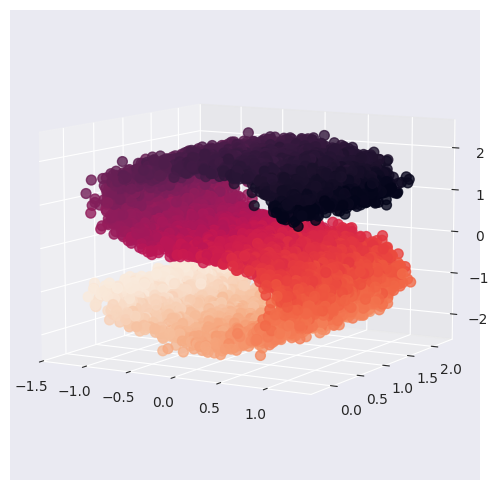

In [66]:
plot_3d(x_te.detach().cpu(), color_te)

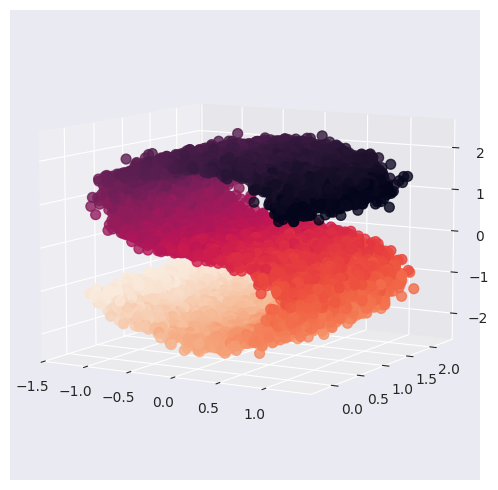

In [72]:
x_re = dpaModel_scurveS.reconstruct(x_te, gen_sample_size=1).cpu()
plot_3d(x_re, color_te)

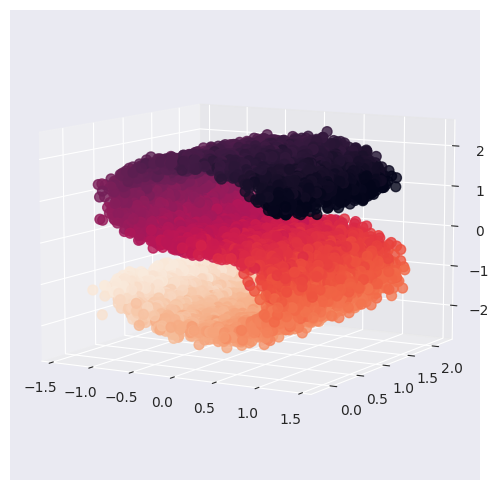

In [75]:
x_re = dpaModel_scurveS.reconstruct(x_te, k=2, gen_sample_size=1).cpu()
plot_3d(x_re, color_te)

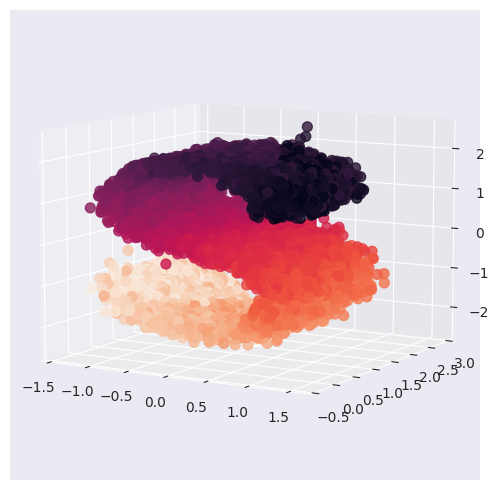

In [78]:
x_re = dpaModel_scurveS.reconstruct(x_te, k=1, gen_sample_size=1).cpu()
plot_3d(x_re, color_te)

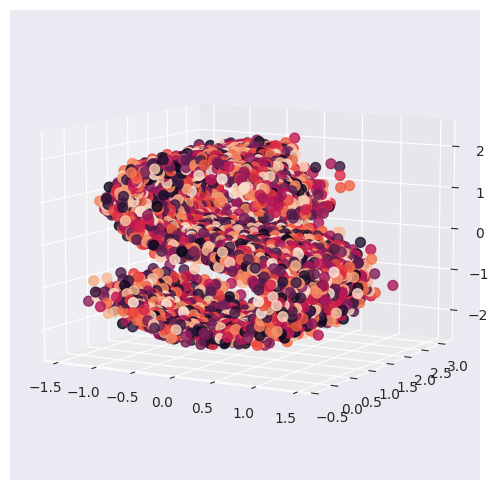

In [79]:
x_re = dpaModel_scurveS.Sreconstruct(x_te, k=0, gen_sample_size=1).cpu()
plot_3d(x_re, color_te)

## Indep

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
@torch.no_grad()
def quick_conditional_r2(enc, x_te, K):
    Z = enc(x_te).cpu().numpy()
    X_np = x_te.cpu().numpy()

    Z_cond = Z[:, :K]

    r2 = []

    for j in range(K, Z.shape[1]):
        z_j = Z[:, j:j + 1]

        z_hat = LinearRegression().fit(Z_cond, z_j).predict(Z_cond)
        res_z = z_j - z_hat

        x_hat = LinearRegression().fit(Z_cond, X_np).predict(Z_cond)
        res_x = X_np - x_hat

        num = (res_z * res_x).sum() ** 2
        den = (res_z ** 2).sum() * (res_x ** 2).sum()
        r2.append(float(num / den))

    return np.array(r2)


In [37]:
print(quick_conditional_r2(dpaModel_scurveS.encode, x_te, K=1))
print(quick_conditional_r2(dpaModel_scurveS.encode, x_te, K=2))

[0.94257855 0.01094402]
[0.00061268]


In [41]:
import dcor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as MI
from sklearn.kernel_ridge import KernelRidge

In [89]:

def residualise(Y, Z):
    if Y.ndim == 1:
        Y = Y[:, None]
    if Z.ndim == 1:
        Z = Z[:, None]

    Z1 = np.hstack([Z, np.ones((Z.shape[0], 1))])
    B, *_ = np.linalg.lstsq(Z1, Y, rcond=None)
    return Y - Z1 @ B


def residualise_krr(Y, Z, alpha=1e-3, gamma=None):
    if Y.ndim == 1:
        Y = Y[:, None]

    model = KernelRidge(alpha=alpha, kernel='rbf', gamma=gamma)
    model.fit(Z, Y)

    return Y - model.predict(Z)


def mi_max(x, Y):
    return max(MI(x, Y[:, j])[0] for j in range(Y.shape[1]))


@torch.no_grad()
def dependence_stats(enc, x_te, K: int, n=4_000, device='cuda'):
    Z = enc.encode(x_te.to(device),
                   k=None,
                   mean=True,
                   gen_sample_size=100,
                   in_training=False).cpu().numpy()

    Xnp = x_te.cpu().numpy()
    Xstd = (Xnp - Xnp.mean(0)) / Xnp.std(0, ddof=1)

    cond = Z[:, :K]

    stats = []

    for i in range(Z.shape[1]):
        zi = Z[:, i:i + 1]

        print(f"distance correlation: {i}")
        dc_u = dcor.distance_correlation(zi, Xstd).item()
        if i < K:
            dc_c = np.nan
        else:
            dc_c = dcor.partial_distance_correlation(zi, Xstd, cond).item()

        print(f"MI: {i}")
        ri = residualise_krr(zi, cond)
        rX = residualise_krr(Xstd, cond)

        mi_u = mi_max(zi, Xstd)
        mi_c = (np.nan if i < K else mi_max(ri, rX))

        stats.append([i + 1, dc_u, dc_c, mi_u, mi_c])

    return stats


In [ ]:
stats_scurveS3 = dependence_stats(dpaModel_scurveS, x_te, K=2, device=device)

In [ ]:
stats_scurveS3_df = pd.DataFrame(stats_scurveS3, columns=['z', 'dCor', 'dCor|zi', 'MIMax', 'MIMax|zi'])

In [94]:
stats_scurveS3_df.to_csv("res/indep/scurve/stats_scurveS3.csv")